<a href="https://colab.research.google.com/github/Soham109/Brain-Tumor-Classification-with-Neural-Networks/blob/main/Brain_Tumor_Classification_with_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#AI assistance code starts

In [ ]:
!pip install google-generativeai rapidfuzz requests beautifulsoup4 easyocr opencv-python textblob

In [ ]:
#BACKEND
import os
import google.generativeai as genai
from rapidfuzz import process
from expr import weights
import requests
from bs4 import BeautifulSoup
import easyocr
import cv2
import os
import re
from textblob import TextBlob

class ai:
    def preprocess_image(self, image_path, flag=False):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if flag:
            _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
            brightness = 40
            contrast = 100
            adjusted = cv2.convertScaleAbs(thresh, alpha=contrast/127, beta=brightness)
            cv2.imwrite(f"./with/preprocessed_{image_path.split('/')[-1]}.jpg", adjusted)
            return adjusted

        cv2.imwrite(f"./without/preprocessed_{image_path.split('/')[-1]}.jpg", gray)
        return gray

    def spell_check(self, text):
        corrected_text = ""
        lines = text.split('\n')
        for line in lines:
            if line.strip():
                try:
                    blob = TextBlob(line)
                    corrected_text += f"{blob.correct()}\n"
                except Exception as e:
                    corrected_text += f"Error processing line: {line} ({e})\n"
        return corrected_text

    def easyocr_extraction(self, image_path):
        reader = easyocr.Reader(["en"])

        def final_ocr(image_path, preprocess=False):
            image = self.preprocess_image(image_path, preprocess)
            result = reader.readtext(image)

            if not result:
                print("No text detected. Try enhancing the image or adjusting settings.")
                return "No text detected."

            extracted_text = "".join([detection[1] for detection in result])
            spell_checked_text = self.spell_check(extracted_text)
            return spell_checked_text

        print("\nOCR Results without preprocessing:")
        res_no_preprocess = final_ocr(image_path, preprocess=False)
        print(res_no_preprocess)

        print("\nOCR Results with preprocessing:")
        res_preprocess = final_ocr(image_path, preprocess=True)
        print(res_preprocess)

        return res_no_preprocess + "\n" + res_preprocess

    def extract_drug_info(self, drug_name):
        url = f"https://www.drugs.com/search.php?searchterm={drug_name.replace(' ', '+')}"
        print(f"Search URL: {url}")

        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            featured_result = soup.find('div', {'class': 'ddc-media ddc-search-result ddc-search-result-featured ddc-box ddc-box-secondary'})
            if featured_result:
                detailed_link = featured_result.find('a', href=True)
                if detailed_link:
                    detailed_url = detailed_link['href']
                    if not detailed_url.startswith('http'):
                        detailed_url = f"https://www.drugs.com{detailed_url}"
                    print(f"Detailed Page URL: {detailed_url}")


                    detailed_response = requests.get(detailed_url)
                    if detailed_response.status_code == 200:
                        detailed_soup = BeautifulSoup(detailed_response.text, 'html.parser')
                        content_div = detailed_soup.find('div', {'id': 'content'})
                        if content_div:
                            formatted_response = ""
                            sections = content_div.find_all('h2')
                            for section in sections:
                                section_title = section.text.strip()
                                formatted_response += f"\n### {section_title} ###\n"

                                next_siblings = section.find_all_next(['p', 'ul'], limit=10)
                                for sibling in next_siblings:
                                    if sibling.name == 'p':
                                        formatted_response += f"{sibling.text.strip()}\n"
                                    elif sibling.name == 'ul':
                                        for li in sibling.find_all('li'):
                                            formatted_response += f"- {li.text.strip()}\n"

                            return formatted_response
                        else:
                            print("Content section not found in the detailed page.")
                    else:
                        print(f"Failed to retrieve detailed page. Status code: {detailed_response.status_code}")
                else:
                    print("No detailed link found in the featured section.")
            else:
                print("No featured result section found on the search page.")
        else:
            print(f"Failed to retrieve search page. Status code: {response.status_code}")

    def fuzzy_match(self, query, choices, threshold=75):
        match = process.extractOne(query, choices)
        if match and match[1] >= threshold:
            return match
        else:
            return None


    def main(self, inp, image_path):
        if not os.path.exists(image_path):
            return f"Error: File not found: {image_path}"
        else:
            finalised = self.easyocr_extraction(image_path)

            genai.configure(api_key="")

            # Create the model
            generation_config = {
                "temperature": 1,
                "top_p": 0.95,
                "top_k": 40,
                "max_output_tokens": 8192,
                "response_mime_type": "text/plain",
            }

            model = genai.GenerativeModel(
                model_name="gemini-2.0-flash-exp",
                generation_config=generation_config,
            )

            chat_session = model.start_chat(history=[])

            query = f"""
            image ocr output:{finalised}
            extract the drug name from this.
            Note: do not include citations and those.
            Just give the name of tablet as response nothing more.
            """
            response = chat_session.send_message(query)

            drug_name = response.text.strip()

            final_info = self.extract_drug_info(drug_name)

            finalquery = f"""
            query: {inp}
            drug_details: {final_info}
            Note: do not include citations and those.
            Just answer the query with the details about the drug.
            Basic detailes to be included in any type of query: Drugname, Use, Safe Dose, Side Effects(if available in drug_details)
            """
            finalresponse = chat_session.send_message(finalquery)

            return finalresponse.text


In [ ]:
#FRONTEND
import streamlit as st
from PIL import Image
from ai import ai
import os

st.set_page_config(
    page_title="Pill/Tablet AI Assistant",
    layout="wide",
    initial_sidebar_state="expanded"
)

if "messages" not in st.session_state:
    st.session_state["messages"] = []

def history():
    st.sidebar.markdown("<div class='sidebar-title'>Chat History</div>", unsafe_allow_html=True)
    for message in st.session_state["messages"]:
        if message["user"] == "User":
            st.sidebar.markdown(f"**User**: {message['content']}")
        else:
            st.sidebar.markdown(f"**AI**: {message['content']}")

st.title("💊 Pill/Tablet AI Assistant")

st.subheader("Upload an Image of the Tablet/Pill*")
uploaded_file = st.file_uploader(
    " ",
    type=["png", "webp", "jpg"],
    accept_multiple_files=False,
    label_visibility="visible"
)

st.subheader("Enter Your Query")
query_input = st.text_input(
    " ",
    placeholder="Ask a question about the uploaded pill/tablet. Eg: 'What is this tablet used for?'"
)

aih = ai()
if st.button("Submit Query"):
    if uploaded_file and query_input.strip():

        temp_path = f"/tmp/{uploaded_file.name}"
        with open(temp_path, "wb") as f:
            f.write(uploaded_file.getbuffer())

        st.write(query_input)
        try:

            ai_response = f"The AI is processing your query about '{uploaded_file.name}'..."
            st.write(ai_response)

            ai_response = aih.main(inp=query_input, image_path=temp_path)
            st.write(ai_response)
        except Exception as e:
            ai_response = f"An error occurred: {str(e)}"
            st.error(ai_response)


        st.session_state["messages"].append({"user": "User", "content": query_input})
        st.session_state["messages"].append({"user": "AI", "content": ai_response})

    elif not uploaded_file:
        st.error("Please upload an image before submitting your query.")
    elif not query_input.strip():
        st.error("Please enter a query before submitting.")


history()


In [ ]:
#AI assistance code ends

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

: 

In [ ]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:04<00:00, 41.8MB/s]
100% 149M/149M [00:04<00:00, 35.8MB/s]


In [ ]:
def get_class_paths(path):
  classes = []
  classpaths = []

  for lable in os.listdir(path):
    lable_path = os.path.join(path ,lable)

    if os.path.isdir(lable_path):

      for image in os.listdir(lable_path):
        image_path = os.path.join(lable_path , image)

        classes.append(lable)
        classpaths.append(image_path)

  df = pd.DataFrame({
      'Class Path' : classpaths,
      'Class' : classes
  })
  return df


In [ ]:
tr_df = get_class_paths('/content/Training')
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_0794.jpg,notumor
1,/content/Training/notumor/Tr-no_1039.jpg,notumor
2,/content/Training/notumor/Tr-no_0972.jpg,notumor
3,/content/Training/notumor/Tr-no_0559.jpg,notumor
4,/content/Training/notumor/Tr-no_1252.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_0255.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0182.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0553.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0380.jpg,glioma


In [ ]:
ts_df = get_class_paths('/content/Testing')
ts_df

,Class Path,Class
0,/content/Testing/notumor/Te-no_0097.jpg,notumor
1,/content/Testing/notumor/Te-no_0301.jpg,notumor
2,/content/Testing/notumor/Te-noTr_0000.jpg,notumor
3,/content/Testing/notumor/Te-no_0222.jpg,notumor
4,/content/Testing/notumor/Te-no_0139.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0280.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0163.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0194.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0146.jpg,glioma


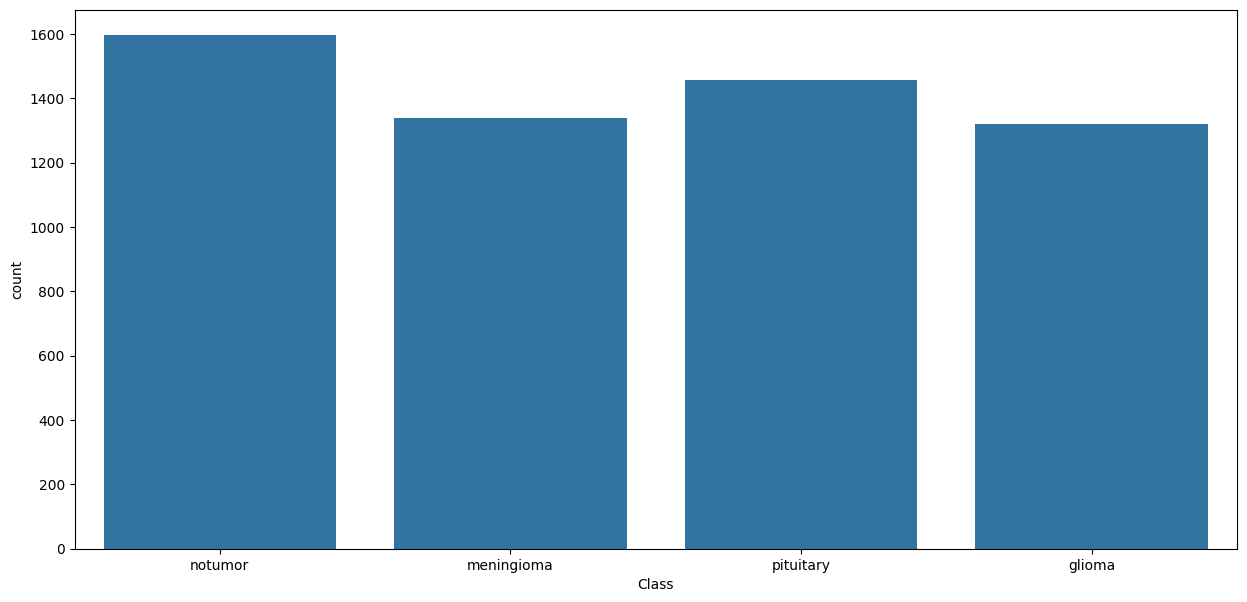

In [ ]:
plt.figure(figsize = (15,7))
ax = sns.countplot(data = tr_df , x = tr_df['Class'])

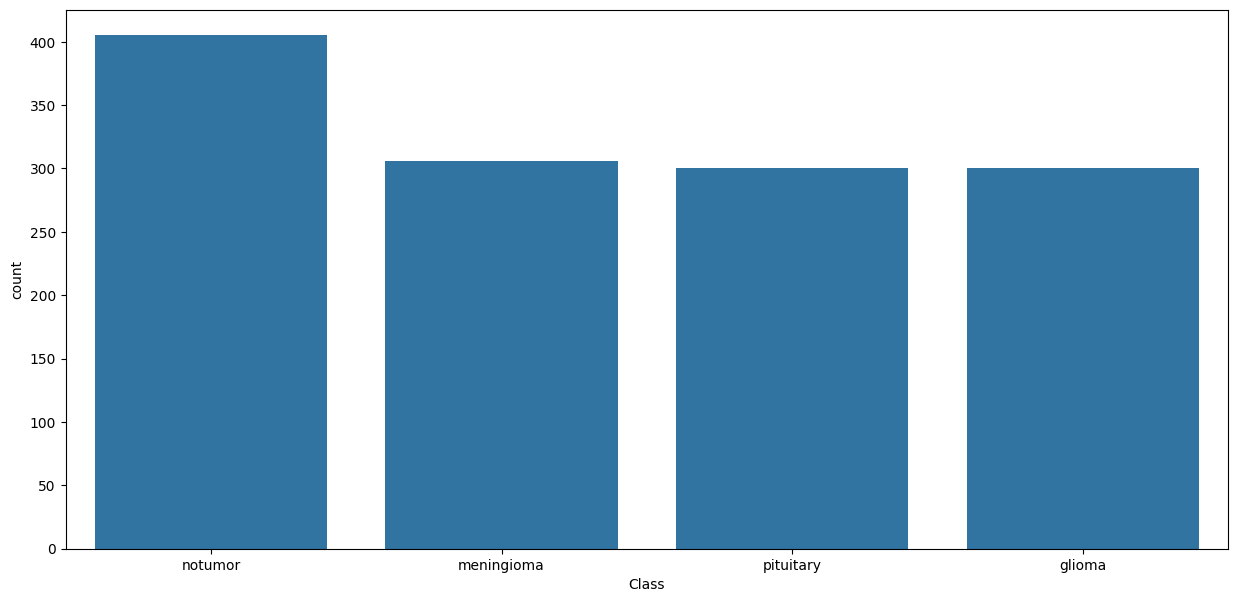

In [ ]:
plt.figure(figsize = (15,7))
ax = sns.countplot(data = ts_df , x = ts_df['Class'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision , Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
valid_df , ts_df = train_test_split(ts_df , train_size=0.5 , stratify=ts_df['Class'])

In [ ]:
batch_size = 32

image_size = (299,299)

image_generator = ImageDataGenerator(rescale = 1/255 , brightness_range = (0.8,1.2))

ts_generator = ImageDataGenerator(rescale = 1/255 )

In [ ]:
tr_gen = image_generator.flow_from_dataframe(
    tr_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

ts_gen = ts_generator.flow_from_dataframe(
    ts_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = 16,
    target_size = image_size, shuffle = False
)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

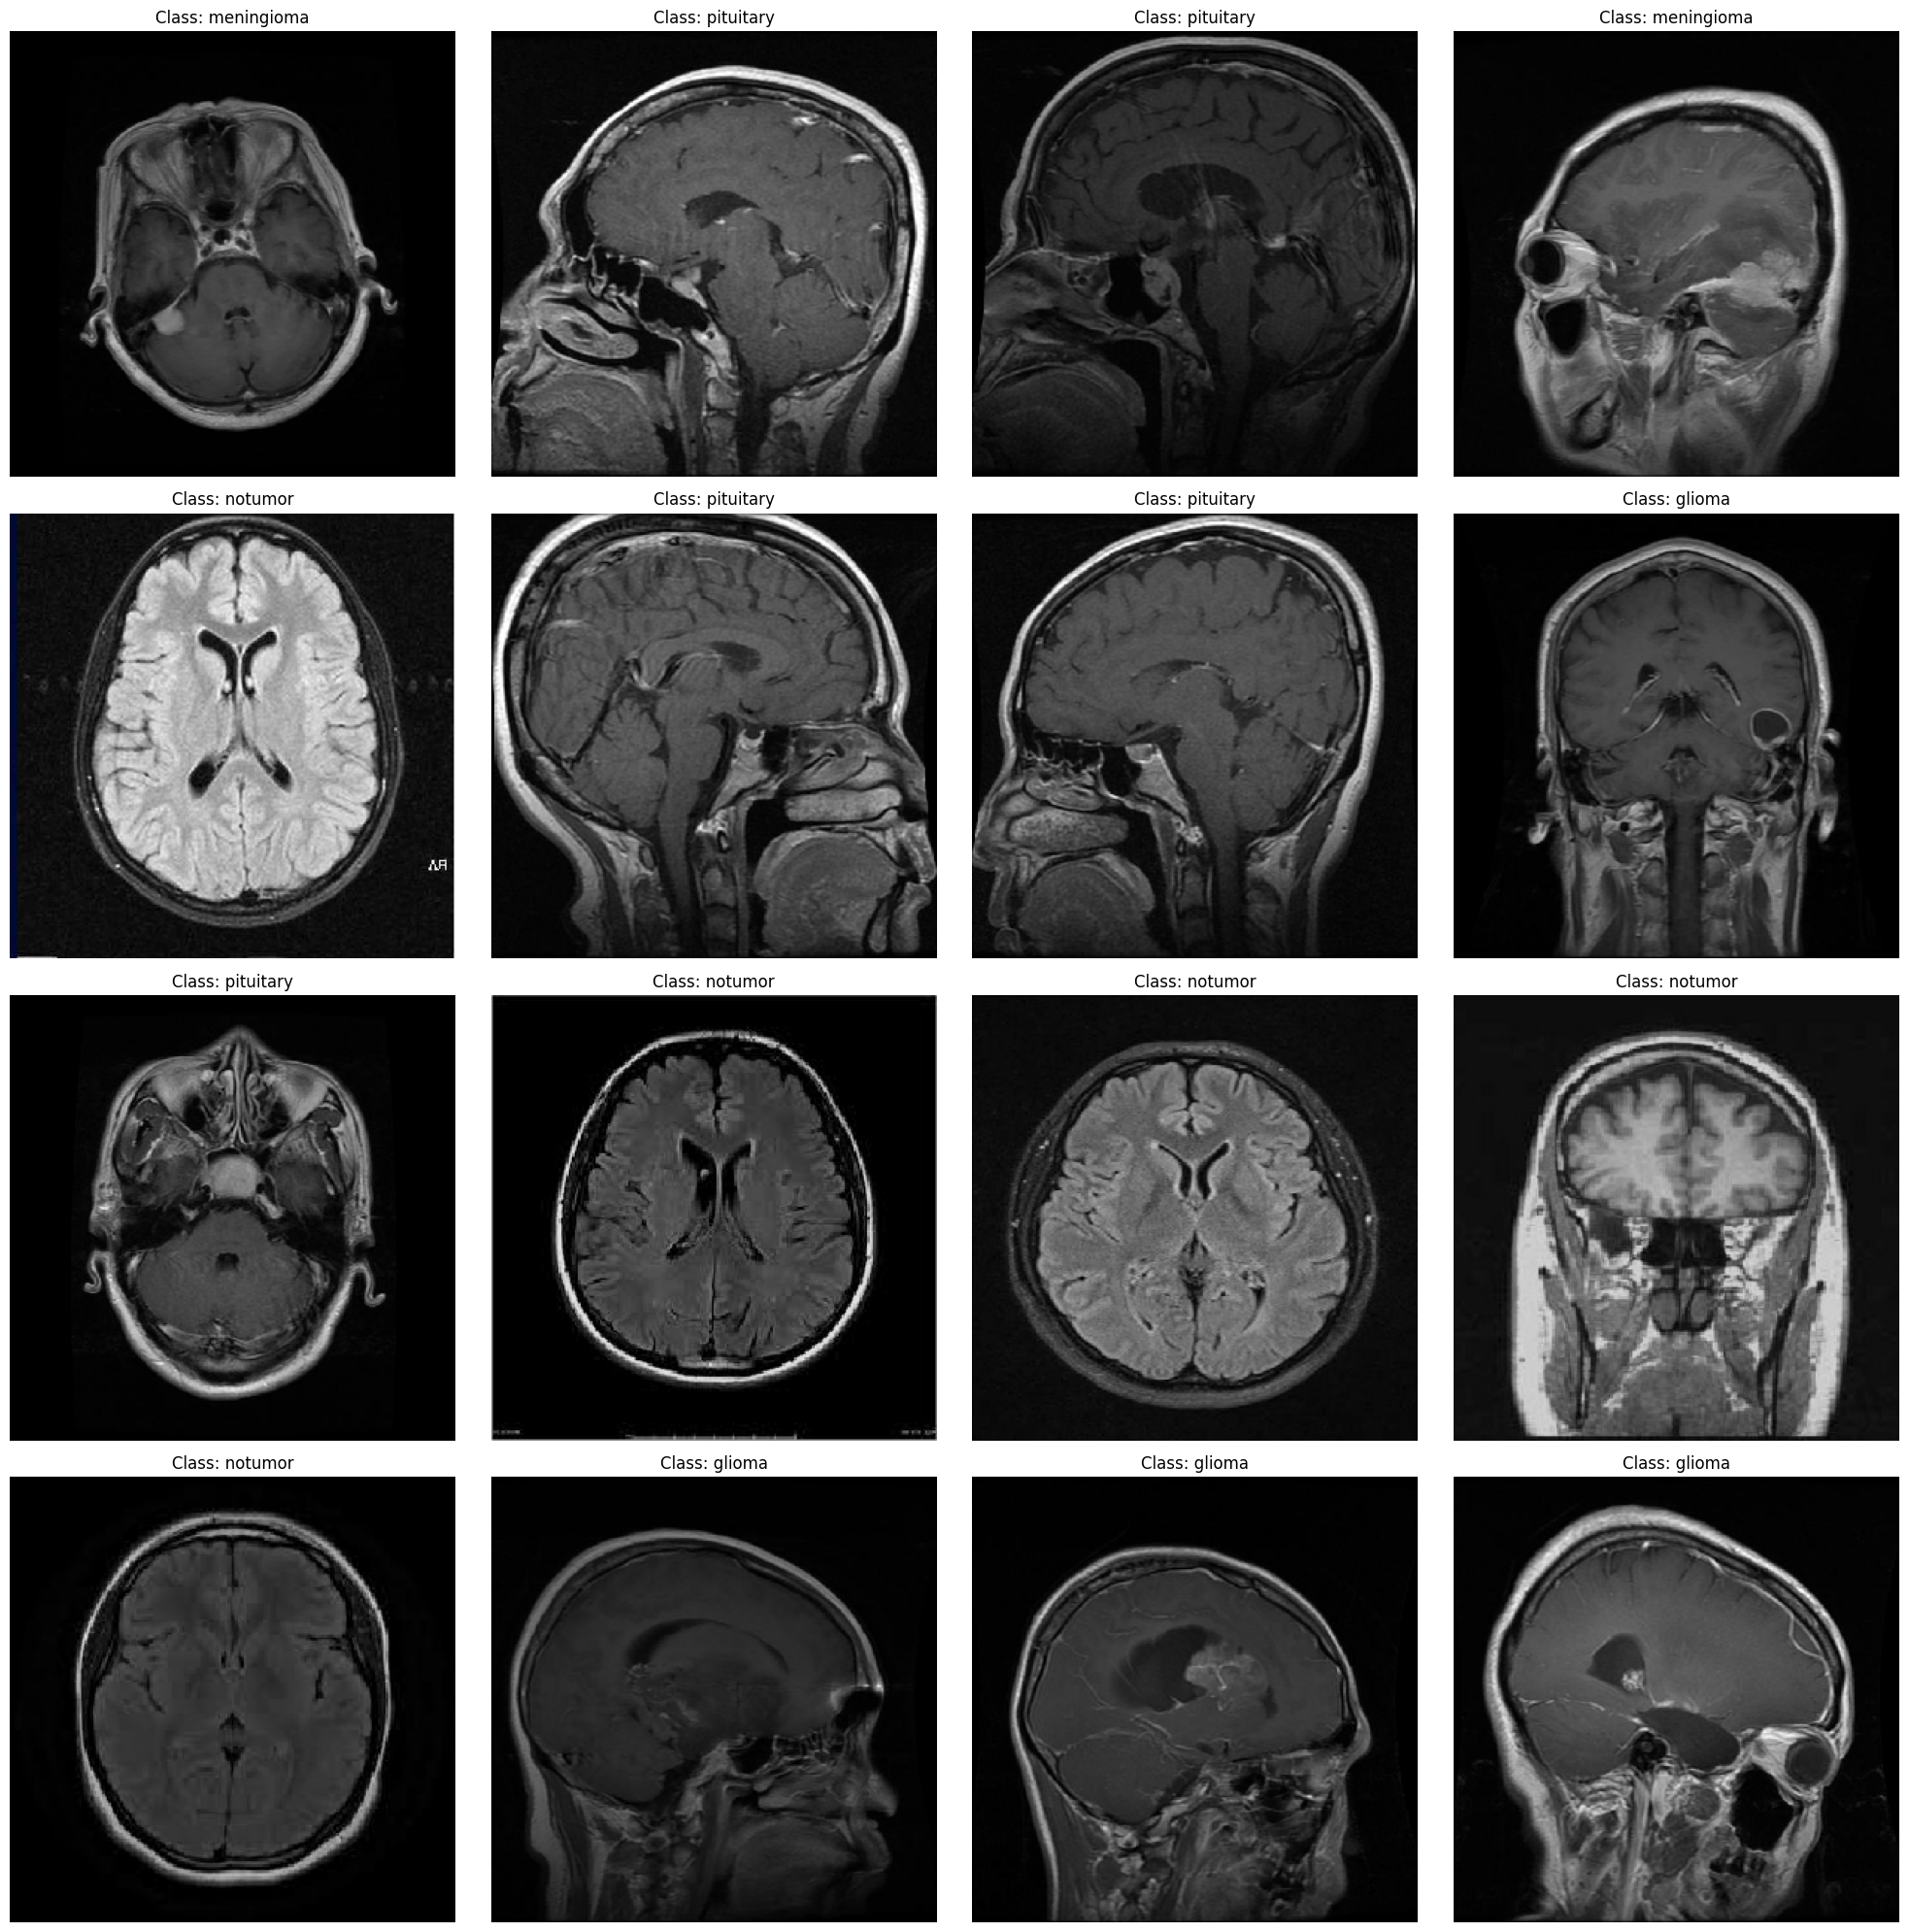

In [ ]:
plt.figure(figsize=(20,20))
for i in range (16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  lable =batch[1][0]
  plt.imshow(image)

  class_index = np.argmax(lable)

  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  index_position = class_indices.index(class_index)

  class_name = class_names[index_position]

  plt.title(f'Class: {class_name}')
  plt.axis('off')

plt.tight_layout()
plt.show

In [ ]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = img_shape,
    pooling = 'max'
)

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate = 0.3),      # used to prevent overfitting
    Dense(128, activation = 'relu'),
    Dropout(rate = 0.25),
    Dense(4, activation = 'softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.compile(Adamax(learning_rate= 0.001),
              loss = 'categorical_crossentropy',
              metrics = [
                  'accuracy',
                  Precision(),
                  Recall()
              ])

In [ ]:
hist = model.fit(
    tr_gen,
    epochs = 5,
    validation_data = valid_gen,)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7709 - loss: 0.6796 - precision: 0.8324 - recall: 0.6384 - val_accuracy: 0.9084 - val_loss: 0.2603 - val_precision: 0.9298 - val_recall: 0.8901
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 800ms/step - accuracy: 0.9822 - loss: 0.0576 - precision: 0.9839 - recall: 0.9805 - val_accuracy: 0.9756 - val_loss: 0.0756 - val_precision: 0.9770 - val_recall: 0.9725
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 144s 798ms/step - accuracy: 0.9883 - loss: 0.0380 - precision: 0.9885 - recall: 0.9882 - val_accuracy: 0.9756 - val_loss: 0.0729 - val_precision: 0.9786 - val_recall: 0.9756
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 803ms/step - accuracy: 0.9949 - loss: 0.0169 - precision: 0.9955 - recall: 0.9949 - val_accuracy: 0.9771 - val_loss: 0.0734 - val_precision: 0.9786 - val_recall: 0.9756
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 802ms/step - accuracy: 0.9969 - loss: 0.0086 - precision: 0.9973 - recall: 0.9969 - val_accuracy: 0.9557 - val_loss: 

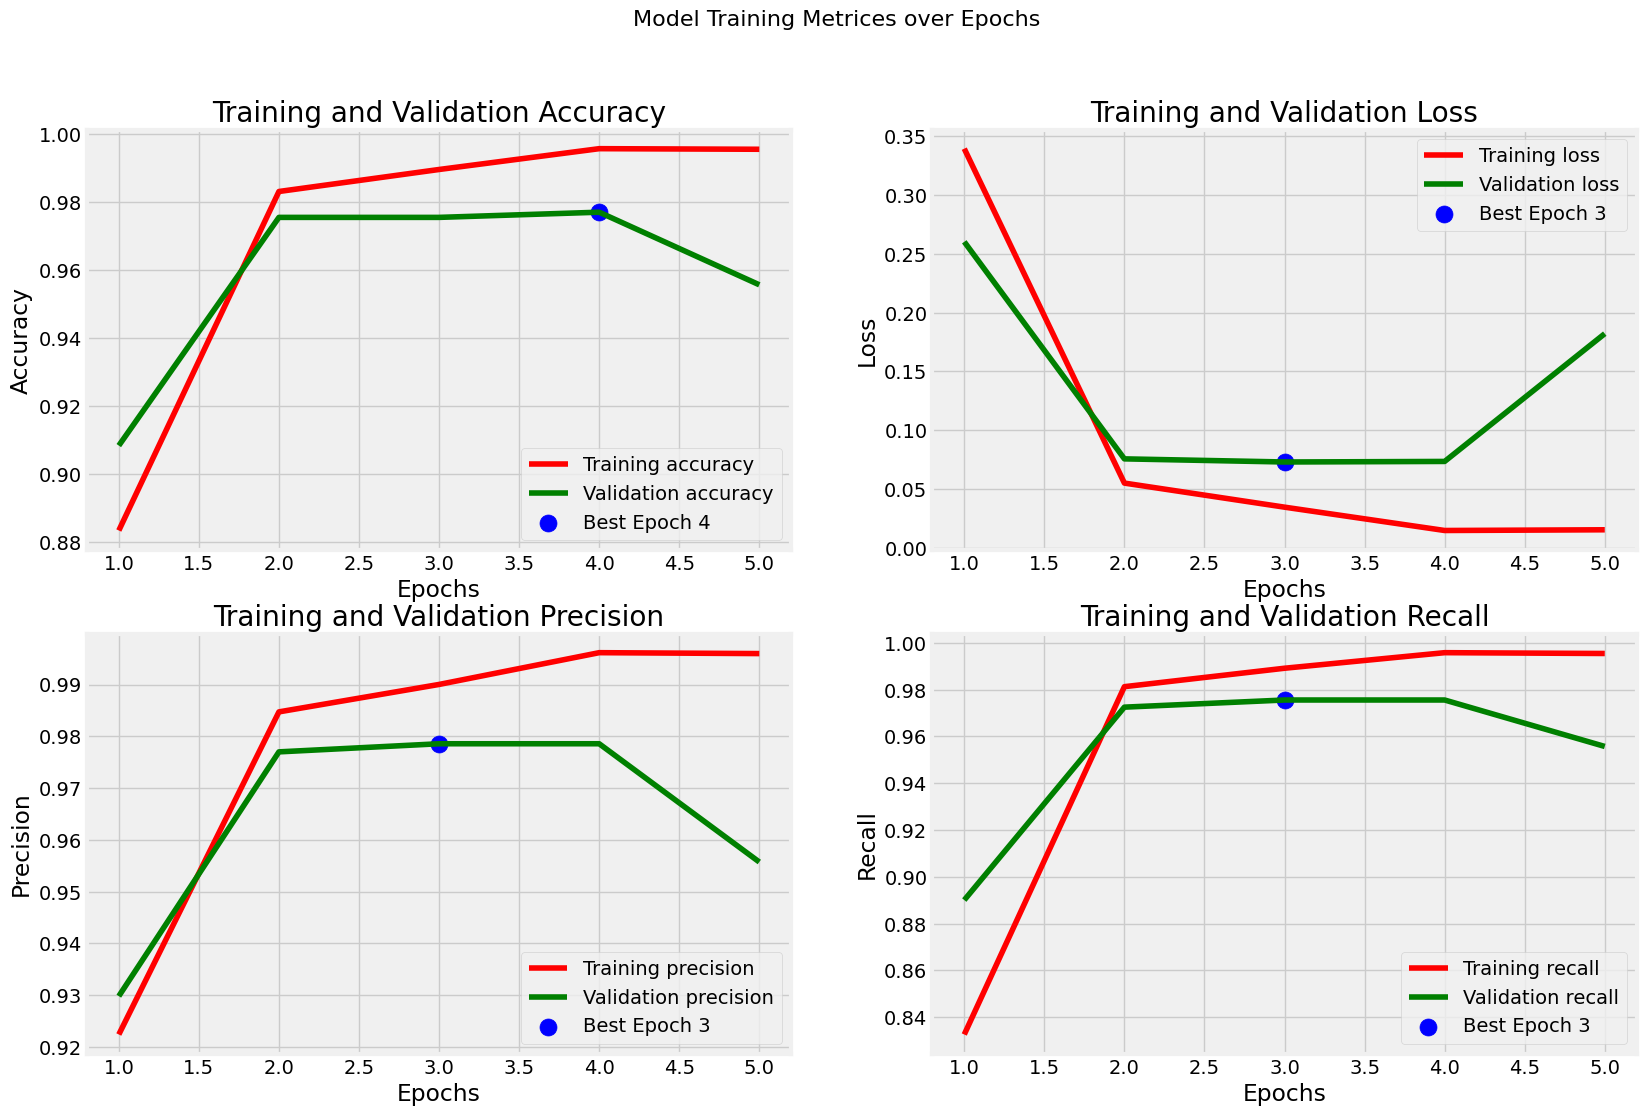

In [ ]:
metrics = ['accuracy' , 'loss' , 'precision' , 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}

for m in metrics:
    if m == 'loss' :
      idx = np.argmin(val_metrics[m])
    else:
      idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx+1
    best_values[m] = val_metrics[m][idx]

plt.figure(figsize = (20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics,1):
    plt.subplot(2,2,i)
    epochs = range(1,len(tr_metrics[metric]) +1 )

    plt.plot(epochs , tr_metrics[metric], 'r', label = f'Training {metric}')
    plt.plot(epochs , val_metrics[metric], 'g', label = f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150 , c = 'b',
              label = f'Best Epoch {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrices over Epochs', fontsize = 16)
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen , verbose = 1)
valid_score = model.evaluate(valid_gen , verbose = 1)
test_score = model.evaluate(ts_gen , verbose = 1)

print(f'Train Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.9854 - loss: 0.0510 - precision: 0.9855 - recall: 0.9854
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.9558 - loss: 0.1842 - precision: 0.9609 - recall: 0.9558
 1/41 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.7500 - loss: 1.0271 - precision: 0.7500 - recall: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9449 - loss: 0.2526 - precision: 0.9449 - recall: 0.9449
Train Accuracy: 98.62%
Train Loss: 0.0417


Validation Accuracy: 95.42%
Validation Loss: 0.1843


Test Accuracy: 96.80%
Test Loss: 0.1327


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step


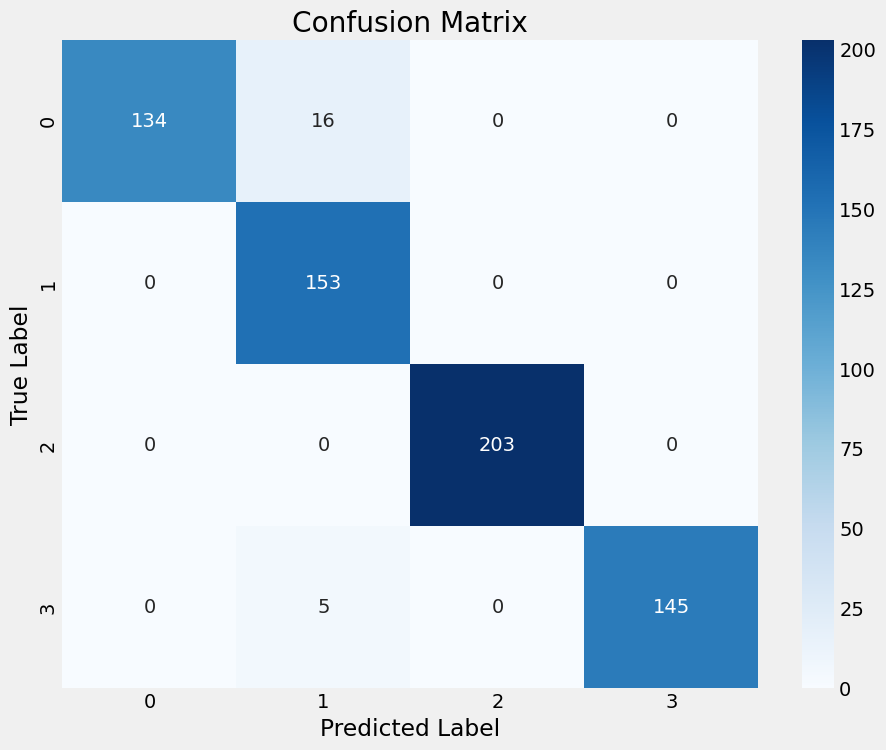

In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds , axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituatary'
}

cm = confusion_matrix(ts_gen.classes , y_pred)
labels = list(class_dict.keys())
plt.figure(figsize = (10,8))
sns.heatmap(cm , annot = True, fmt = 'd' , cmap = 'Blues', xticklabels = labels , yticklabels = labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from PIL import Image

def predict(img_path: str) -> None:

  #get class labels
  labels = list(class_dict.keys())

  plt.figure(figsize=(6,8))

  #load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array , axis = 0) /255.0

  #get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  #Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[ predicted_class_idx]

  #plot original image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f'Input MRI Image/nPredicted: {predicted_class}')

  #plot prediction probabilites
  plt.subplot(2,1,2)
  bars = plt.barh(labels , probabilities)
  plt.xlabel('Probabilites', fontsize = 15)
  plt.title('Class Probabilities')

  #add probability labels to bar
  ax = plt.gca()
  ax.bar_label(bars , fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f'Predicted Tumour type: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


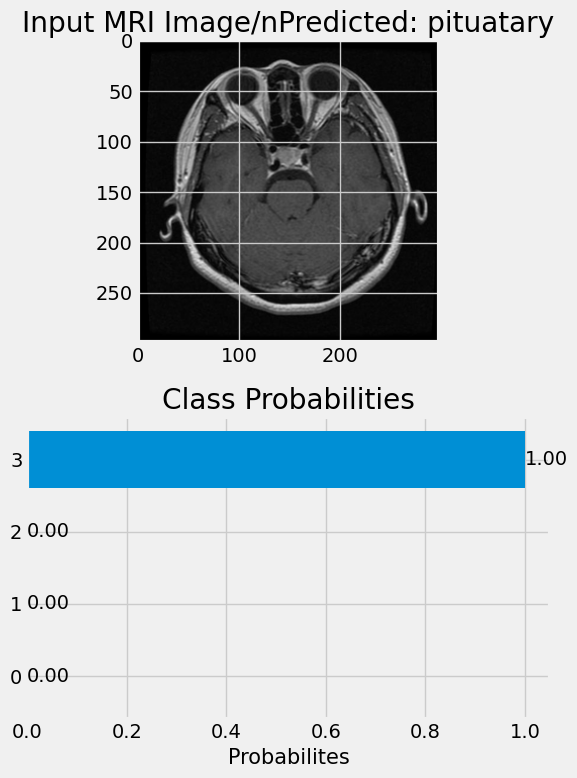

Predicted Tumour type: pituatary


In [ ]:
predict("/content/Testing/pituitary/Te-pi_0011.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

In [ ]:
from tensorflow.keras.layers import Conv2D , MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [ ]:
batch_size = 16
image_size = (224, 224)

image_generator = ImageDataGenerator(rescale = 1/255 , brightness_range = (0.8,1.2))
ts_generator = ImageDataGenerator(rescale = 1/255 )

tr_gen = image_generator.flow_from_dataframe(
    tr_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

ts_gen = ts_generator.flow_from_dataframe(
    ts_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = 16,
    target_size = image_size, shuffle = False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
# Create a Sequential model
cnn_model = Sequential()

# Convolution layers with Batch Normalization
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

# Output layer
cnn_model.add(Dense(4, activation='softmax'))

# Compile the model
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics =['accuracy', Precision(), Recall()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(
    tr_gen ,
    epochs = 10 ,
    validation_data = valid_gen,)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 106s 295ms/step - accuracy: 0.7896 - loss: 0.7703 - precision_3: 0.8229 - recall_3: 0.7536 - val_accuracy: 0.7908 - val_loss: 0.6759 - val_precision_3: 0.8087 - val_recall_3: 0.7679
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 293ms/step - accuracy: 0.8449 - loss: 0.5543 - precision_3: 0.8605 - recall_3: 0.8247 - val_accuracy: 0.8427 - val_loss: 0.5345 - val_precision_3: 0.8504 - val_recall_3: 0.8244
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 104s 290ms/step - accuracy: 0.8778 - loss: 0.4578 - precision_3: 0.8876 - recall_3: 0.8625 - val_accuracy: 0.8855 - val_loss: 0.4254 - val_precision_3: 0.8873 - val_recall_3: 0.8779
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 292ms/step - accuracy: 0.9075 - loss: 0.3952 - precision_3: 0.9170 - recall_3: 0.9011 - val_accuracy: 0.8901 - val_loss: 0.4007 - val_precision_3: 0.9006 - val_recall_3: 0.8855
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 291ms/step - accuracy: 0.9335 - loss: 0.3144 - precision_3: 0.9375 

In [ ]:
train_score = cnn_model.evaluate(tr_gen , verbose = 1)
valid_score = cnn_model.evaluate(valid_gen , verbose = 1)
test_score = cnn_model.evaluate(ts_gen , verbose = 1)

print(f'Train Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')


357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9818 - loss: 0.1701 - precision_3: 0.9819 - recall_3: 0.9814
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9396 - loss: 0.3145 - precision_3: 0.9414 - recall_3: 0.9387
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9348 - loss: 0.3360 - precision_3: 0.9348 - recall_3: 0.9348
Train Accuracy: 98.13%
Train Loss: 0.1675


Validation Accuracy: 95.11%
Validation Loss: 0.2705


Test Accuracy: 93.60%
Test Loss: 0.3192


In [ ]:
cnn_model.save("cnn_model.h5")

In [ ]:
!pip install streamlit pyngrok python-dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [ ]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [ ]:
pip install --upgrade h5py

In [ ]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key = os.getenv("GOOGLE_API_KEY"))

output_dir = 'saliency_maps'
os.makedirs(output_dir , exist_ok=True)


def generate_explanation(img_path , model_prediction, confidence):

  prompt = f"""You are an expert neurologist tasked with interpreting a saliency map from a brain tumor MRI scan.
  The saliency map was generated by a deep learning model trained to classify brain tumors into one of the following categories: glioma, meningioma, pituitary, or no tumor.

  The model has predicted that this MRI scan is of class {model_prediction} with a confidence level of {confidence * 100}%.

  In your response:
  - Describe which areas of the brain the model focused on, referring specifically to the regions highlighted in light cyan.
  - Provide potential reasons for the model’s classification based on these regions.
  - Avoid phrases such as 'The saliency map highlights the regions the model is focusing on, which are in light cyan.'
  - Limit your explanation to a maximum of 4 sentences.
  - Think step by step for this and verify each step.
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  return response.text


def generate_saliency_map(model, img_array, class_index, img_size):
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]

    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

    # Apply mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

def load_xception_model(model_path):
  img_shape = (299,299,3)

  base_model = tf.keras.applications.Xception(
      include_top = False,
      weights = 'imagenet',
      input_shape = img_shape,
      pooling = 'max'
  )

  model = Sequential([
      base_model,
      Flatten(),
      Dropout(rate = 0.3),      # prevents over fitting
      Dense(128, activation = 'relu'),
      Dropout(rate = 0.25),
      Dense(4, activation = 'softmax')    #what is softmax and relu?
  ])

  model.build((None,)+img_shape)

  model.compile(Adamax(learning_rate= 0.001),      #What is adamax?
              loss = 'categorical_crossentropy',
              metrics = [
                  'accuracy',
                  Precision(),
                  Recall()
              ])
  model.load_weights(model_path)

  return model


st.title('Brain Tumor Classification')
st.write('Upload an MRI scan to classify')

uploaded_file = st.file_uploader("Choose an Image....." , type=["jpg","jpeg","png"])

if uploaded_file is not None:
  selected_model = st.radio(
      "Select Model",
      ("Transfer Learning - Xception" , "Custom CNN")
  )
  if selected_model == "Transfer Learning - Xception":
    model = load_xception_model('/content/xception_model.weights.h5')
    img_size = (299,299)
  else:
    model = load_model('/content/cnn_model.h5')
    img_size = (224,224)


  labels = ['Glioma', 'Meningioma' , 'No Tumor' , 'Pituitary']
  img = image.load_img(uploaded_file, target_size = img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array , axis =0)
  img_array /= 255.0

  prediction = model.predict(img_array)

  class_index = np.argmax(prediction[0])
  result = labels[class_index]

  st.write(f'Predicted Class: {result}')
  st.write('Predictions: ')
  for label,prob in zip (labels,prediction[0]):
    st.write(f"{label}: {prob*100:.2f}%")

  saliency_map = generate_saliency_map(model , img_array, class_index, img_size)

  col1,col2 = st.columns(2)
  with col1:
    st.image(uploaded_file,caption = "Uploaded Image" , use_container_width = True)
  with col2:
    st.image(saliency_map, caption = "Saliency Map" , use_container_width = True)


  st.write("## Classification Results")

  result_container = st.container()
  result_container = st.container()
  result_container.markdown(
     f"""



                  Prediction

                      {result}




                  Confidence

                      {prediction[0][class_index]:.4%}




      """,
      unsafe_allow_html=True
  )

  # Prepare data for Plotly chart
  probabilities = prediction[0]
  sorted_indices = np.argsort(probabilities)[::-1]
  sorted_labels = [labels[i] for i in sorted_indices]
  sorted_probabilities = probabilities[sorted_indices]

  # Create a Plotly bar chart
  fig = go.Figure(go.Bar(
      x=sorted_probabilities,
      y=sorted_labels,
      orientation='h',
      marker_color=['red' if label == result else 'blue' for label in sorted_labels]
  ))

  # Customize the chart layout
  fig. update_layout(
    title='Probabilities for each class',
    xaxis_title='Probability',
    yaxis_title='Class',
    height=400,
    width=600,
    yaxis=dict (autorange="reversed"))

  # Add value labels to the bars
  for i, prob in enumerate(sorted_probabilities):
    fig. add_annotation(
      x=prob,
      y=1,
      text=f'{prob:.4f}',
      showarrow=False,
      xanchor='left',
      xshift=5)

  st.plotly_chart(fig)

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'
  explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])

  st.write("## Explanation")
  st.write(explanation)

Overwriting app.py


In [ ]:
thread = Thread(target = run_streamlit)
thread.start()

In [ ]:
public_url = ngrok.connect(addr = '8501' , proto = 'http' , bind_tls = True)
print(f'Public URL: {public_url}')

Public URL: NgrokTunnel: "https://7d38-34-147-88-165.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pkill ngrok

Overwriting app.py
